<a href="https://colab.research.google.com/github/AtsushiNi/myLeprecon/blob/master/niihama/plasma_data_12_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 概要
露光時間が短すぎてデータが綺麗に撮れなかったと判明<br>
露光時間を7秒に増やしてプラズマを撮った<br>
とりあえず感度校正は後回し

In [ ]:
!pip install git+https://github.com/fujiisoup/pyspectra.git
!pip install netCDF4

  Cloning https://github.com/fujiisoup/pyspectra.git to /tmp/pip-req-build-81ssnlsn
  Running command git clone -q https://github.com/fujiisoup/pyspectra.git /tmp/pip-req-build-81ssnlsn
  Created wheel for pyspectra: filename=pyspectra-0.0.1-cp36-none-any.whl size=18787 sha256=c5e3514bc101b46ba4aff8d93e4a3a1bacde66a6c68f0b60779bd85f214607d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-psvw43p5/wheels/a7/c4/4a/152e6df7ccc3c6838abee31c086e30a3690c80966eb588e7a2
Successfully built pyspectra
     |████████████████████████████████| 4.7MB 8.3MB/s 
     |████████████████████████████████| 296kB 43.2MB/s 


In [ ]:
import os
from os.path import join
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyspectra
import pandas as pd
import math
from scipy import interpolate
from scipy import integrate
from scipy.optimize import curve_fit
from sympy.physics.wigner import wigner_3j
from functools import reduce

In [ ]:
data_path = '/content/drive/MyDrive/研究室/myLeprecon/SpectrometerData/20201217_niihama'
print(os.path.exists(data_path))

In [ ]:
file_names = [f'H_{430000 + 5000*i}.nc' for i in range(8)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data_array['exposure'] = data_array.attrs['exposure']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

plasma_data = []
for i, p in enumerate(data['motor_coordinate']):
  d = data.sel(motor_coordinate=p).copy()
  d['long_x'] = d['x'][::-1] - 1000 * i
  d['x'] = data['x']
  plasma_data.append(d.sum('y'))
plasma_data = xr.concat(plasma_data, dim='motor_coordinate')

In [ ]:
file_names = [f'back_{430000 + 5000*i}.nc' for i in range(8)]
data = []
for file_name in file_names:
    data_array = xr.open_dataarray(join(data_path, file_name))
    data_array['motor_coordinate'] = data_array.attrs['motor_coordinate']
    data_array['exposure'] = data_array.attrs['exposure']
    data.append(data_array)
data = xr.concat(data, dim='motor_coordinate')

back_data = []
for i, p in enumerate(data['motor_coordinate']):
    d = data.sel(motor_coordinate=p).copy()
    d['long_x'] = d['x'][::-1] - 1000 * i
    d['x'] = data['x']
    back_data.append(d.sum('y'))
back_data = xr.concat(back_data, dim='motor_coordinate')

In [ ]:
spectrum_data = plasma_data - back_data * 1.0

plt.figure(figsize=[15, 10])
plt.subplot(3, 1, 1)
plt.ylim(1.2*1e6, 5*1e6)
plt.title('plasma')
for f in plasma_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 2)
plt.title('back ground')
plt.ylim(1.03*1e6, 1.9*1e6)
for f in back_data:
  plt.plot(f['long_x'], f)

plt.subplot(3, 1, 3)
plt.title('H2 spectrum')
for f in spectrum_data:
  plt.plot(f['long_x'], f)

# 波長校正

In [ ]:
def fit(da):
  popt, perr = pyspectra.fit.singlepeak_fit(da['x'].values, da.values)
  return xr.Dataset({
      'A': popt[0], 'x0': popt[1], 'w': popt[2], 'y0': popt[3],
      'data': da,
      'fit': ('x', pyspectra.profiles.Gauss(da['x'].values, *popt))},
      coords={'x': da['x']})

## (v' - v") = (0 - 0)

In [ ]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=465000).plot()
#plt.xlim(210, 310)
#plt.ylim(0, 400000)

In [ ]:
spectrum_lims = [
  [1120, 1165],
  [990, 1040],
  [815, 860],
  [570, 610],
  [210, 310],
#  [240, 280]
]
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
  610.9030
]
plt.figure(figsize=(35, 10))
result_00 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=465000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=465000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_00.append(result)
result_00 = xr.concat(result_00, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_00['x0'], result_00['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

## (v' - v") = (1 - 1)

In [ ]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=455000).plot()
#plt.xlim(0, 310)
#plt.ylim(0, 400000)

In [ ]:
spectrum_lims = [
  [750, 800],
  [610, 680],
  [435, 480],
  [180, 227],
]
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
plt.figure(figsize=(35, 5))
result_11 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=455000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=455000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_11.append(result)
result_11 = xr.concat(result_11, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_11['x0'], result_11['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

## (v' - v") = (2 - 2)

In [ ]:
plt.figure(figsize=(30, 5))
spectrum_data.sel(motor_coordinate=445000).plot()
#plt.xlim(0, 310)
#plt.ylim(0, 400000)

In [ ]:
spectrum_lims = [
  [345, 390],
  [215, 260],
  [18, 63],
]
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
  627.8369,
  629.6622,
  631.7233

]
plt.figure(figsize=(35, 5))
result_22 = []

for i, lims in enumerate(spectrum_lims):
    result = fit(spectrum_data.sel(motor_coordinate=445000).sel(x=slice(spectrum_lims[i][0], spectrum_lims[i][1])))
    result['v'] = 0
    result['N'] = i+1
    result['wave_length'] = wave_lengths[i]
    result['long_x'] = spectrum_data.sel(motor_coordinate=445000).isel(x=int(result['x0'].values.tolist()))['long_x']
    plt.subplot(2, len(spectrum_lims), i+1)
    result['data'].plot(marker='.')
    result['fit'].plot()
    plt.title('N = {}'.format(i+1))
    plt.xlabel('pixels')
    plt.ylabel('intensity')
    result_22.append(result)
result_22 = xr.concat(result_22, dim='N')

plt.figure(figsize=[35, 10])
plt.subplot(2, i+1, i+2)
plt.plot(result_22['x0'], result_22['wave_length'], marker='o')
plt.title('x0 --- wave length')
plt.xlabel('x0 (pixel)')
plt.ylabel('wave length (nm)')

# ピクセルを波長に変換

In [ ]:
wavelength = np.concatenate([result_00['wave_length'].values, result_11['wave_length'].values, result_22['wave_length'].values])
longx = np.concatenate([result_00['long_x'].values, result_11['long_x'].values, result_22['long_x'].values])

longx_to_wavelength_fun = np.poly1d(np.polyfit(longx, wavelength, 3))
x = np.linspace(-6200, -500, 100)

plt.plot(longx, wavelength, marker='x', linestyle='None')
plt.plot(x, longx_to_wavelength_fun(x))
plt.xlabel('long_x (pixel)')
plt.ylabel('wavelength (nm)')

In [ ]:
array = []
for a in spectrum_data:
    d = a.assign_coords(wavelength=('x', longx_to_wavelength_fun(a['long_x'])))
    array.append(d)
spectrum_data = xr.concat(array, dim='motor_coordinate')

plt.figure(figsize=(10, 6))
plt.xlabel('wavelength (nm)')
plt.ylabel('count (a.u.)')
for s in spectrum_data:
    plt.plot(s['wavelength'], s)

# 数値積分

## (v' - v") = (0 - 0)

In [ ]:
func465000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=465000)['wavelength'], spectrum_data.sel(motor_coordinate=465000), kind='linear')
func460000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=460000)['wavelength'], spectrum_data.sel(motor_coordinate=460000), kind='linear')
func455000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=455000)['wavelength'], spectrum_data.sel(motor_coordinate=455000), kind='linear')
func450000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=450000)['wavelength'], spectrum_data.sel(motor_coordinate=450000), kind='linear')
func445000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=445000)['wavelength'], spectrum_data.sel(motor_coordinate=445000), kind='linear')
func440000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=440000)['wavelength'], spectrum_data.sel(motor_coordinate=440000), kind='linear')
func435000 = interpolate.interp1d(spectrum_data.sel(motor_coordinate=435000)['wavelength'], spectrum_data.sel(motor_coordinate=435000), kind='linear')

In [ ]:
plt.figure(figsize=(30, 5))
data = spectrum_data.sel(motor_coordinate=465000)
plt.plot(data['wavelength'], data)
data = spectrum_data.sel(motor_coordinate=460000)
plt.plot(data['wavelength'], data)
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
#  610.9030
]
for w in wave_lengths:
  plt.axvline(w)


In [ ]:
array_00 = []
wave_lengths = [
  601.8299,
  602.3757,
  603.1909,
  604.2716,
  605.6091,
  607.1996,
  609.0374,
#  610.9030
]
args = [
  {"func": func465000, "start": 601.73, "end": 601.94, "N": 1},
  {"func": func465000, "start": 602.29, "end": 602.46, "N": 2},
  {"func": func465000, "start": 603.07, "end": 603.275, "N": 3},
  {"func": func465000, "start": 604.17, "end": 604.34, "N": 4},
  {"func": func465000, "start": 605.50, "end": 605.80, "N": 5},
  {"func": func460000, "start": 607.075, "end": 607.28, "N": 6},
  {"func": func460000, "start": 608.92, "end": 609.2, "N": 7},
]

for arg in args:
  array_00.append({
    "v": 0,
    "N": arg['N'],
    "wavelength": wave_lengths[arg['N'] - 1],
    "intensity": integrate.quad(arg['func'], arg['start'], arg['end'])
  })
array_00

## (v' - v") = (1 - 1)

In [ ]:
plt.figure(figsize=(30, 5))
data = spectrum_data.sel(motor_coordinate=455000)
plt.plot(data['wavelength'], data)
data = spectrum_data.sel(motor_coordinate=450000)
plt.plot(data['wavelength'], data)
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
for w in wave_lengths:
  plt.axvline(w)

In [ ]:
array_11 = []
wave_lengths = [
  612.1787,
  612.7246,
  613.5395,
  614.6186,
  615.9565
]
args = [
  {"func": func450000, "start": 612.05, "end": 612.27, "N": 1},
  {"func": func450000, "start": 612.6, "end": 612.85, "N": 2},
  {"func": func450000, "start": 613.425, "end": 613.62, "N": 3},
  {"func": func450000, "start": 614.52, "end": 614.75, "N": 4},
  {"func": func450000, "start": 615.85, "end": 616.05, "N": 5},
]

for arg in args:
  array_11.append({
    "v": 1,
    "N": arg['N'],
    "wavelength": wave_lengths[arg['N'] - 1],
    "intensity": integrate.quad(arg['func'], arg['start'], arg['end'])
  })
array_11

## (v' - v") = (2 - 2)

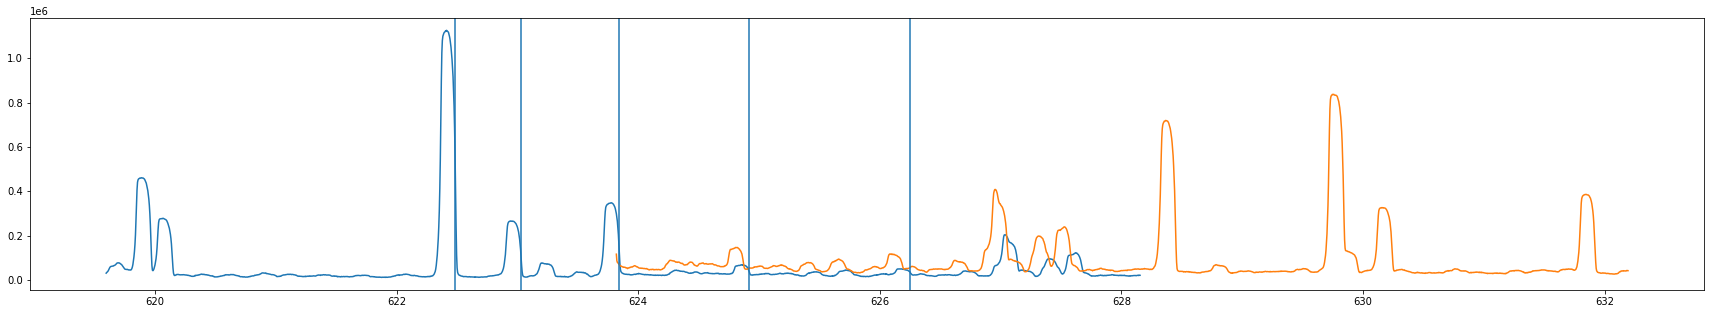

In [ ]:
plt.figure(figsize=(30, 5))
data = spectrum_data.sel(motor_coordinate=440000)
plt.plot(data['wavelength'], data)
data = spectrum_data.sel(motor_coordinate=435000)
plt.plot(data['wavelength'], data)
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
#  627.8369,
#  629.6622,
#  631.7233
]
for w in wave_lengths:
  plt.axvline(w)


In [ ]:
array_22 = []
wave_lengths = [
  622.4815,
  623.0258,
  623.8391,
  624.9150,
  626.2495,
#  627.8369,
#  629.6622,
#  631.7233
]
args = [
  {"func": func440000, "start": 622.33, "end": 622.52, "N": 1},
  {"func": func440000, "start": 622.86, "end": 623.05, "N": 2},
  {"func": func440000, "start": 623.67, "end": 623.875, "N": 3},
  {"func": func440000, "start": 624.77, "end": 624.93, "N": 4},
  {"func": func440000, "start": 626.1, "end": 626.28, "N": 5},
]

for arg in args:
  array_22.append({
    "v": 2,
    "N": arg['N'],
    "wavelength": wave_lengths[arg['N'] - 1],
    "intensity": integrate.quad(arg['func'], arg['start'], arg['end'])
  })
array_22

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


[{'N': 1,
  'intensity': (136015.44881131506, 4.9187363607634325),
  'v': 2,
  'wavelength': 622.4815},
 {'N': 2,
  'intensity': (33196.78688983189, 0.8871012551317108),
  'v': 2,
  'wavelength': 623.0258},
 {'N': 3,
  'intensity': (44305.85463274163, 1.2522203640037333),
  'v': 2,
  'wavelength': 623.8391},
 {'N': 4,
  'intensity': (8851.059742525926, 2.0278981068638102),
  'v': 2,
  'wavelength': 624.915},
 {'N': 5,
  'intensity': (7188.620728462394, 0.10313532087002386),
  'v': 2,
  'wavelength': 626.2495}]

# 上準位回転・振動状態数分布
$$n_{dv'N'}=\frac{I^{dv'N'}_{av"N"}\lambda^{dv'N'}_{av"N"}}{hc}\frac{1}{A^{dv'N'}_{av"N"}}$$

## 自然発光係数 A

In [ ]:
A_array = [2.4077e7, 2.0655e7, 1.7377e7, 1.4317e7]
# 自然放出係数
def A(vd, Nd):
  return A_array[vd] * (2*Nd+1) / 2



## 上準位分布 $n_{dv'N'}$

In [ ]:
# プランク定数[ev/s]
planck_constant = 4.13567e-15
# 光速[m/s]
light_speed = 299792458
for d in array_00:
  d['nd'] = d['intensity'][0] * d['wavelength'] / planck_constant / light_speed / A(d['v'], d['N']) 
for d in array_11:
  d['nd'] = d['intensity'][0] * d['wavelength'] / planck_constant / light_speed / A(d['v'], d['N']) 
for d in array_22:
  d['nd'] = d['intensity'][0] * d['wavelength'] / planck_constant / light_speed / A(d['v'], d['N'])

In [ ]:
result = np.zeros((10, 3))
for i in range(len(array_00)):
  result[i][0] = array_00[i]['nd']
for i in range(len(array_11)):
  result[i][1] = array_11[i]['nd']
for i in range(len(array_22)):
  result[i][2] = array_22[i]['nd']
print('発光上準位の振動・回転状態占有数(相対値)')
result


発光上準位の振動・回転状態占有数(相対値)


array([[5656244.66955995, 7127775.26319211, 2619883.90648468],
       [ 884468.57554993, 1629359.02167514,  383990.68721919],
       [1021436.08614626, 1240873.11704829,  366542.45440195],
       [ 144895.01277891,  188944.00930458,   57050.87715304],
       [ 176622.60957735,  142956.63147051,   37991.71440719],
       [  68006.72955478,       0.        ,       0.        ],
       [ 129603.25524108,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ]])

# 上準位回転温度 $T^{dv'}_{rot}$


## 上準位ボルツマンフィッティング

In [ ]:
# d状態の回転エネルギー
def e_rot(v, N):
  return ((30.364-1.545*(v+1/2))*N*(N+1)-0.0191*N*(N+1)*N*(N+1))*1.23984/1e4

# 核スピンの縮退度(核スピンの統計重率)
def g_as(N):
  return (N % 2) * 2 + 1

# 回転の統計重率(もしかしたら二乗じゃ無いかも)
def g_N(N):
  return (2*N+1)*(2*N+1)

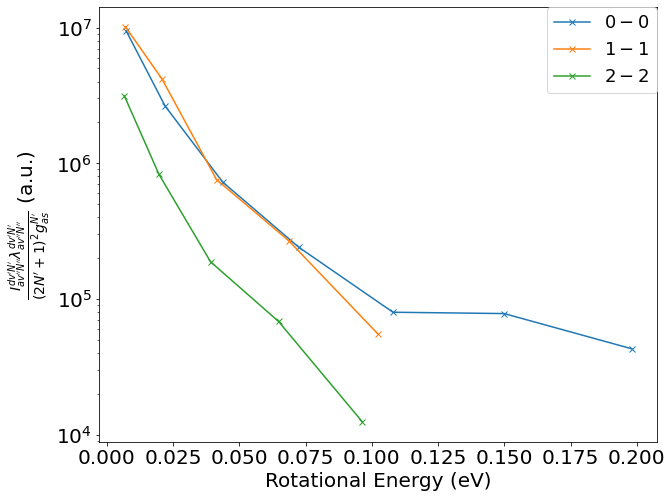

In [ ]:
plt.figure(figsize=[10, 8])
plt.rcParams['font.size'] = 20

for d in array_00:
  d['population'] = d['intensity'][0] * d['wavelength'] / g_N(d['N']) / g_as(d['N'])
  d['energy'] = e_rot(d['v'], d['N'])
for d in array_11:
  d['population'] = d['intensity'][0] * d['wavelength'] / g_N(d['N']) / g_as(d['N'])
  d['energy'] = e_rot(d['v'], d['N'])
for d in array_22:
  d['population'] = d['intensity'][0] * d['wavelength'] / g_N(d['N']) / g_as(d['N'])
  d['energy'] = e_rot(d['v'], d['N'])

energy_00 = np.fromiter(map(lambda Q: Q['energy'], array_00), dtype=np.float)
population_00 = np.fromiter(map(lambda Q: Q['population'], array_00), dtype=np.float)
energy_11 = np.fromiter(map(lambda Q: Q['energy'], array_11), dtype=np.float)
population_11 = np.fromiter(map(lambda Q: Q['population'], array_11), dtype=np.float)
energy_22 = np.fromiter(map(lambda Q: Q['energy'], array_22), dtype=np.float)
population_22 = np.fromiter(map(lambda Q: Q['population'], array_22), dtype=np.float)

plt.plot(energy_00, population_00, marker='x', label="$0-0$")
plt.plot(energy_11, population_11, marker='x', label="$1-1$")
plt.plot(energy_22, population_22, marker='x', label="$2-2$")

plt.yscale('log')

plt.xlabel('Rotational Energy (eV)')
plt.ylabel(r"$\frac{I^{dv'N'}_{av''N''}\lambda^{dv'N'}_{av''N''}}{(2N'+1)^2g^{N'}_{as}}$ (a.u.)")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)

#plt.savefig(data_path, bbox_inches='tight')

## 回転温度 $T^{dv'}_{rot}$

上準位回転温度:  500 K


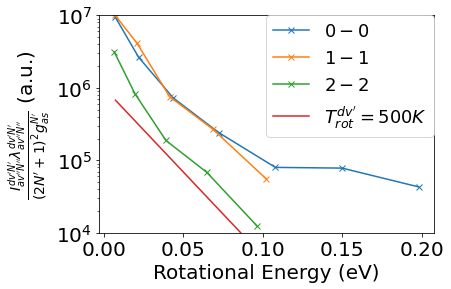

In [ ]:
plt.plot(energy_00, population_00, marker='x', label="$0-0$")
plt.plot(energy_11, population_11, marker='x', label="$1-1$")
plt.plot(energy_22, population_22, marker='x', label="$2-2$")

plt.yscale('log')

plt.xlabel('Rotational Energy (eV)')
plt.ylabel(r"$\frac{I^{dv'N'}_{av''N''}\lambda^{dv'N'}_{av''N''}}{(2N'+1)^2g^{N'}_{as}}$ (a.u.)")
plt.ylim(1e4, 1e7)

T_d_rot = 500 # 上準位の回転温度
const = 6 # 位置合わせのための定数
kb = 8.6171e-5 # [eV K^-1] ボルツマン定数

fit_population_00 = []
for e in energy_00:
  fit_population_00.append(10**(const - e / kb / T_d_rot))

plt.plot(energy_00, fit_population_00, label="$T^{dv'}_{rot}=500K$")

plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)

print('上準位回転温度: ', T_d_rot, 'K')
#plt.savefig(data_path, bbox_inches='tight')

# 基底準位回転温度 $T^{Xv}_{rot}$
$$T^{Xv}_{rot} = \frac{B^{Xv}}{B^{dv'}}T^{dv'}_{rot}$$


In [ ]:
# 石原さん修論より

Be = [60.853, 30.364, 1.671] # X, d, a準位のBe
ae = [3.062, 1.545, 1.671] # X, d, a準位のαe
De = [0.0471, 0.0191, 0.0216] # X, d, a準位のDe
we = [4401.21, 2371.57, 2664.83] # X, d, a準位のwe
wx = [121.33, 66.27, 71.65] # X, d, a準位のwx
# Te = 18 # 電子温度[ev]　ユンさんの研究内容より
Te = 5 / kb # 電子温度[K]　絶対違うけど、とりあえず

# 基底準位の回転定数
def BXv(v):
  return Be[0] - ae[0]*(v+0.5)

# 上準位の回転定数
def Bdv(v):
  return Be[1] - ae[1]*(v+0.5)

# 基底準位の回転温度
T_X_rot = [BXv(0) / Bdv(0) * T_d_rot, BXv(1) / Bdv(1) * T_d_rot, BXv(2) / Bdv(2) * T_d_rot]

# 基底準位の回転エネルギー
def E_X_rot(v, N):
  return (BXv(v)*N*(N+1) - De[0]*N*(N+1)*N*(N+1))*1.23984/1e4

# 基底準位の振動エネルギー
def E_X_vib(v):
  return (we[0]*(v+0.5) - wx[0]*(v+0.5)*(v+0.5))*1.23984/1e4

# 上準位の振動エネルギー
def E_d_vib(v):
  return (we[1]*(v+0.5) - wx[1]*(v+0.5)*(v+0.5))*1.23984/1e4

In [ ]:
print('基底準位の回転温度[v]')
print(T_X_rot)
print(Te)

基底準位の回転温度[v]
[1002.3486474156431, 1002.9771985809282, 1003.6790370356395]
58024.16126074897


# 基底状態振動温度$T^{Xv}_{biv}$

石原さん修論より<br>
- 基底準位はボルツマン分布に従うと仮定する
$$\frac{n_{XvN}}{(2N+1)g^N_{as}}=n_X\exp\left(-\frac{E^{Xv}_{rot}(N)}{k_BT^{Xv}_{rot}}\right)exp\left(-\frac{E^{X}_{vib}(v)}{k_BT^{X}_{vib}}\right)$$
- コロナモデル
$$n_e\sum_{v, N}[n_{XvN}R^{dv'N'}_{XvN}]= n_{dv'N'}\sum_{v"N"}A^{dv'N'}_{av"N"}$$
を、0<v≦2でN',Nについて和をとると(要確認)

\begin{align}
n_{dv'}\sum_{v"=0}^2A^{dv'}_{av"}=n_e\sum_{v=0}^2[n_{Xv}R^{dv'}_{Xv}]\notag \\\propto\sum_{v=0}^2\left[R^{dv'}_{Xv}\exp\left(-\frac{E^X_{vib}(v)}{k_BT^X_{vib}}\right)\right]\tag{#}
\end{align}

上式において
$$R^{dv'}_{Xv}=q^{dv'}_{Xv}<\sigma^{FC}_{v'\leftarrow v}v_e>$$
(要確認! 次式から計算できるのかどうか)
$$R^{dv'N'}_{XvN}=q^{dv'}_{Xv}<\sigma^{FC}_{v'\leftarrow v}v_e>a^{1N'}_{0N}\delta^{g^{N'}_{as}}_{g^N_{as}}$$

## 電子衝突励起係数 R

In [ ]:
# Franck-Condin因子
franck_condon = np.loadtxt('/content/drive/MyDrive/研究室/myLeprecon/franck_condon_factor.txt')
# 振動励起の電子衝突断面積(の多分相対値)
def ccs(vX, vd):
  return np.exp(-((E_d_vib(vd)-E_d_vib(0))-(E_X_vib(vX) - E_X_vib(0)))/ kb / Te)

# 電子速度で平均化した部分断面積　石原さんの修論より
Qr = np.array([0.76,0.122,0.1,0.014])
# 回転構造の分岐比
def branch_ratio(NX, Nd):
  rtp_value = 0
  for r in range(1, 5, 1):
    rtp_value += Qr[r-1]*(2*Nd+1)*(wigner_3j(Nd, r, NX, 1, -1, 0))**2
  return rtp_value

# 禁止遷移は励起係数は0
def kronecker_delta(NX, Nd):
  if(NX % 2 == Nd % 2):
    return 1
  else:
    return 0

# 電子衝突励起係数
def R(vX, NX, vd, Nd):
  return franck_condon[vX][vd] * ccs(vX, vd) * branch_ratio(NX, Nd) * kronecker_delta(NX, Nd)
def R(vX, vd):
  return franck_condon[vX][vd] * ccs(vX, vd)

## フィッティング

In [ ]:
# (#)式の左辺
A_sum = 0
n_sum = np.array([0, 0, 0])
for item in array_00:
  A_sum += A(0, item['N'])
  n_sum[0] += item['nd']
for item in array_11:
  A_sum += A(1, item['N'])
  n_sum[1] += item['nd']
for item in array_22:
  A_sum += A(1, item['N'])
  n_sum[2] += item['nd']

left_formula = np.fromiter(map(lambda a: a * A_sum, n_sum), dtype=np.float)

# 右辺を計算する
def right_formula(T_X_vib, _vds):
  result = np.zeros(3)
  tmp = np.zeros((3, 3))
  for vd in range(0, 3, 1):
    for vX in range(0, 3, 1):
      result[vd] += R(vX, vd) * math.exp(-E_X_vib(vX)/kb/T_X_vib)
      tmp[vX][vd] = R(vX, vd) * math.exp(-E_X_vib(vX)/kb/T_X_vib)
  print(tmp.T)
  return result

def fitting_func(vds, constant, T_X_vib):
  return left_formula - constant * right_formula(T_X_vib, vds)

vds = np.array([0, 1, 2])
#popt, pcov = curve_fit(fitting_func, vd, np.zeros(3), p0=[1000, 1e-270])
a = right_formula(1000, vds)
print(a)
b = right_formula(100, vds)
print(b)

[[4.40769751e-03 3.60871991e-05 1.63744803e-07]
 [7.11689954e-03 1.89514471e-05 1.38939969e-10]
 [7.12956142e-03 3.12793816e-06 3.65956682e-08]]
[0.00444395 0.00713585 0.00713273]
[[2.74784451e-15 9.22998980e-41 3.97886453e-65]
 [4.43681384e-15 4.84719424e-41 3.37612739e-68]
 [4.44470750e-15 8.00029872e-42 8.89244747e-66]]
[2.74784451e-15 4.43681384e-15 4.44470750e-15]


核融合境界〜の(5)より
$$\sum_{N'}\left(\sum_{N"}\frac{I^{dv'N'}_{av"N"}\lambda^{dv'N'}_{av"N"}}{hc}\right) = \frac{A^{dv'}_{av"}}{\sum_{v"}A^{dv'}_{av"}} \times n_e\sum_v\left\{R^{dv'}_{Xv}N_{X0}\exp\left[-\frac{E^X_{vib}(v)}{k_BT^X_{vib}}\right]\right\}$$

In [ ]:
left_formula = np.zeros(3)
for Nd in range(1, 8):
  for Na in range(1, 8):
    if not Nd != Na:
      continue # 上準位と下準位でNは変わらない
    left_formula[0] += array_00[Na-1]['intensity'][0] * array_00[Na-1]['wavelength']
for Nd in range(1, 6):
  for Na in range(1, 6):
    if not Nd != Na:
      continue # 上準位と下準位でNは変わらない
    left_formula[1] += array_11[Na-1]['intensity'][0] * array_11[Na-1]['wavelength']
for Nd in range(1, 6):
  for Na in range(1, 6):
    if not Nd != Na:
      continue # 上準位と下準位でNは変わらない
    left_formula[2] += array_22[Na-1]['intensity'][0] * array_22[Na-1]['wavelength']
left_formula

array([3.10005371e+09, 2.12499238e+09, 5.72089240e+08])

[T_X_vib, constant] =
[1.79420446e+04 6.66531057e+09]


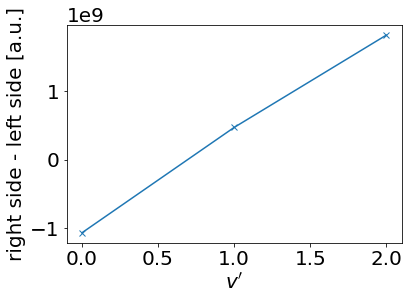

In [ ]:
# v'=v"なので右辺前半は常に1になる？？
def right_formula_func(T_X_vib, _vds):
  right_formula = np.zeros(3)
  for vX in range(0, 3):
    right_formula[0] += R(vX, 0)*math.exp(-E_X_vib(vX)/kb/T_X_vib)
  for vX in range(0, 3):
    right_formula[1] += R(vX, 1)*math.exp(-E_X_vib(vX)/kb/T_X_vib)
  for vX in range(0, 3):
    right_formula[2] += R(vX, 2)*math.exp(-E_X_vib(vX)/kb/T_X_vib)
  return right_formula

vds = np.array([0, 1, 2])

def fitting_func(vds, T_X_vib, constant):
  return constant * right_formula_func(T_X_vib, vds) - left_formula
plt.plot(vds, fitting_func(vds, 2687.12124, 4.61271711e10), marker='x') # これを[0, 0, 0]にするようなfitting_funcの第二、第三引数を求める
plt.xlabel("$v'$")
plt.ylabel('right side - left side [a.u.]')
popt, pcov = curve_fit(fitting_func, vds, np.zeros(3), p0=[2000, 1e11])
print('[T_X_vib, constant] =')
print(popt)
T_X_vib = popt[0]

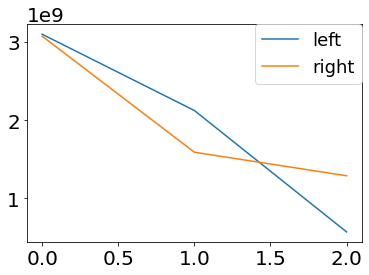

In [ ]:
plt.plot(vds, left_formula, label='left')
plt.plot(vds, popt[1] * right_formula_func(popt[0], vds), label='right')
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)


# 基底準位占有数分布
基底準位はボルツマン分布に従うと仮定する
$$\frac{n_XvN}{(2N+1)g^N_{as}}=exp(-\frac{E^{Xv}_{rot}(N)}{k_BT^{Xv}_{rot}})exp(-\frac{E^{X}_{vib}(v)}{k_BT^{X}_{vib}})$$

[0.0146866  0.04391965 0.08741884 0.14476372 0.21539368 0.29860798
 0.39356568 0.49928575 0.61464696 0.73838795 0.86910721 1.00526307
 1.1451737  1.28701715]
[0.01392732 0.04164181 0.08286317 0.13717094 0.20400451 0.28266314
 0.3723059  0.47195174 0.58047945 0.69662766 0.81899486 0.94603938
 1.0760794  1.20729296]
[0.01316804 0.03936398 0.0783075  0.12957816 0.19261534 0.2667183
 0.35104612 0.44461773 0.54631194 0.65486737 0.76888251 0.8868157
 1.0069851  1.12756877]


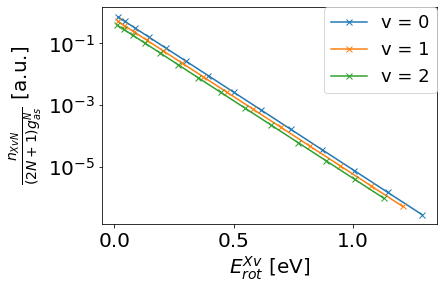

In [ ]:
nX = np.zeros((3, 14))
left = np.zeros((3, 14))
for vX in range(0, 3):
  E_array = np.zeros(14)
  for NX in range(1, 15):
#    nX[vX][NX-1] = (2*NX+1)*g_as(NX)*math.exp(-E_X_rot(vX, NX)/kb/T_X_rot[vX])*math.exp(-E_X_vib(vX)/kb/T_X_vib[vX])
    nX[vX][NX-1] = (2*NX+1)*g_as(NX)*math.exp(-E_X_rot(vX, NX)/kb/T_X_rot[vX])*math.exp(-E_X_vib(vX)/kb/T_X_vib)
    left[vX][NX-1] = math.exp(-E_X_rot(vX, NX)/kb/T_X_rot[vX])*math.exp(-E_X_vib(vX)/kb/T_X_vib)
    E_array[NX-1] = E_X_rot(vX, NX)
  print(E_array)
  plt.plot(E_array, left[vX], marker='x', label=("v = %i" % vX))
nX
plt.yscale('log')
plt.xlabel(r"$E^{Xv}_{rot}$ [eV]")
plt.ylabel(r"$\frac{n_{XvN}}{(2N+1)g^N_{as}}$ [a.u.]")
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=18)

plt.savefig(data_path, bbox_inches='tight')
